In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import gurobipy as gp
from gurobipy import GRB
from itertools import permutations
from itertools import combinations
import random
from random import choice
import time
import copy
import pandas as pd
from scipy.stats import bernoulli

In [2]:
np.random.seed(1)
random.seed(1)

In [3]:
def collection_distribution_mnl(n,collection,v):

    collection_distribution = np.zeros((n,len(collection)))

    
    for i in range(len(collection)):
        curr_total_v = 0
        for j in range(len(collection[i])): 
            curr_total_v = curr_total_v + math.exp(v[collection[i][j]])
            #curr_total_v += v[collection[i][j]]
        #print('the '+str(i)+"th total v",curr_total_v)
        for k in range(len(collection[i])):
            collection_distribution[collection[i][k]][i] = math.exp(v[collection[i][k]])/curr_total_v
            #collection_distribution[collection[i][k]][i]= v[collection[i][k]]/curr_total_v

    return collection_distribution

In [4]:
def gaussian_noise(coll_distribution,std,alpha):
    
    idxs = np.dstack((np.nonzero(coll_distribution)[0],np.nonzero(coll_distribution)[1]))[0]
    temp = copy.deepcopy(coll_distribution)
    temp[temp>0]=1
    for idx in idxs:
        if np.random.random()>alpha:
            temp[idx[0]][idx[1]]=0
    noise = temp*np.random.normal(0,std,size=coll_distribution.shape)
    p_coll_distribution = coll_distribution +noise*coll_distribution
    #p_coll_distribution[p_coll_distribution<0]=math.pow(10,-6)
    p_coll_distribution = p_coll_distribution/p_coll_distribution.sum(axis=0)
    
    return p_coll_distribution

In [5]:
def mdm_feasibility(data,ranking,equal):
    n,m = data.shape
    # for each product, find the assortments it belongs to 
    #prod_occurance = np.transpose(np.nonzero(data[0])).shape[0]  # count the number of assortments within each product , the size of assortment is fixed, all combinations of the products are taken, so the number of assortment including each product is the same
    #ranking = np.argsort(data,axis=1)[:,-prod_occurance:] # probability increasing order # take the last 2 or 3(size) 
    ub = 100
    
    start_time = time.time()
    model = gp.Model('mdm')
    #model.setParam(gp.GRB.Param.TimeLimit, 60)
    model.setParam('OutputFlag', 0)
    eps = model.addVar(name='eps')
    lam = model.addVars(m,name = 'lam')
    
    
    model.addConstr(eps<=ub ) # just give an upper bound (+ve) for eps, o.w., the problem is unbounded
    
    #for i in range(ranking.shape[0]): # from each product 
    for i in range(len(ranking)): # from each product 
        for j in range(len(ranking[i])-1): # the ranking of assortment in product i 
            model.addConstr(lam[ranking[i][j]]- lam [ranking[i][j+1]] - eps >=0)
            
    for i in range(len(equal)):
        for j in range(len(equal[i])-1):
            model.addConstr(lam[equal[i][j]]-lam[equal[i][j+1]]==0)
    
    model.setObjective(eps,GRB.MAXIMIZE)
    model.optimize()
    used_time = time.time() - start_time
    
    # write the model 
    ''' print('write the model')
    model.write("out.sol")
    model.write("model.lp") ''' 
    
    soln = []

    for v in model.getVars():
        soln.append(v.x)

    if (soln[0]>0):
        return [1, used_time]
        #return [1,model.Runtime]
    else:
        return [0, used_time]
        #return [0,model.Runtime]

In [234]:
def rum_feasibility(data):
    curr_time = time.time()
    # data processing for RUM feasibility checking
    n,m = data.shape
    asmnt = []
    for i in range(m):
        curr_assortment = np.where(data[:,i]!=0)
        for j in curr_assortment:
            asmnt.append(list(j))
   
    # flatten the data to dimension 1
    data_zip = data.flatten()
    for j in np.where(data_zip!=0):
        index_in = j
    index_in.astype(int)
    index_in= list(index_in)

    #specify all the possible permutation lists for each element in the probability collection
    perm_tab = [[] for _ in range(n*m)]
    perm = list(permutations(range(n),n))
    perm = [list(i) for i in perm]

    for i in range(m):
        for j in asmnt[i]:
            for p in range(len(perm)):
            #for p in perm:
                new_p = [k for k in perm[p] if k in asmnt[i]]
                if j == new_p[0]:
                    perm_tab[i+j*m].append(p)
    used_time_plit = time.time()-curr_time
    if  used_time_plit >60*30:
        print('spending too much time on find the preference list for each entry in the probability collectioin ')
        print('the time for find the preference list when n = ' +str(n)+'is' + str(used_time_plit))
        return [-1,used_time_plit]
        
    
    start_time = time.time()
    # the RUM feasibility LP
    model = gp.Model('rum')
    #model.setParam('TimeLimit', 60*30)
    #model.Params.TimeLimit = 3
    #model.setParam(gp.GRB.Param.TimeLimit, 3)
    model.setParam('OutputFlag', 0)
    lam = model.addVars(len(perm),name='lam')
    
    model.addConstrs(lam[i]>=0 for i in range(len(perm)))
    model.addConstr(sum(lam[i] for i in range(len(perm)))==1)
    
    # calculation of each probability
    for i in index_in:
        model.addConstr(sum(lam[j] for j in perm_tab[i]) == data_zip[i])
    
    model.setObjective(0)
    #model.write("model.lp")
    model.optimize()
    used_time = time.time() - start_time
    ''' if model.Status == 2:
        model.write("out.sol") '''
    # write the model
    
    if model.Status == 2: #optimal
        #return [1,model.Runtime]
        return [1, used_time]
    
    if model.Status == 3: #infeasible
        #return [0,model.Runtime]
        return [0, used_time]
        
    if model.Status == 9: # meet time limit
        #return [-1,30]
        return [-1, used_time]
    else:
        return [-1, used_time]

In [14]:
def mnl_feasiblity_check(data,collection,n):
    
    actual_prod = np.unique(np.nonzero(data)[0]).tolist()
    start_time = time.time()
    model = gp.Model('mnl')
    model.setParam('OutputFlag', 0)
    v = model.addVars(n,name = 'v') # positive 
  
    for ass_idx in range(len(collection)):
        for i in collection[ass_idx]:
            model.addConstr(data[i][ass_idx]*sum(v[j] for j in collection[ass_idx])-v[i]==0)
    
    model.addConstrs(v[i]>=0 for i in range(n))
    model.addConstrs(v[i]<=100 for i in range(n))
    #model.setObjective(0,GRB.MAXIMIZE)
    model.setObjective(sum(v[i] for i in actual_prod),GRB.MAXIMIZE)
    model.optimize()
    used_time = time.time()-start_time
    
    # write the model 
    print('write the model')
    model.write("out.sol")
    model.write("model.lp") 
    obj = model.getObjective()
    print(obj.getValue())

    if model.Status == 3: #infeasible
        #return [0,model.Runtime]
        return [0, used_time]
    
    if model.Status == 2: #optimal
        soln = []
    
        for v in model.getVars():
            soln.append(v.x)
        #return [1,model.Runtime]
        if sum(soln)==0:  # the value of v cannot be all zero : recall that v here is actually exp(v) in MNL so ,all v should be positive
            return [0, used_time]
        
        for i in actual_prod:
            if soln[i] == 0:
                return[0,used_time]
        return [1,used_time]
        ''' if sum(soln)>0:
            return [1, used_time] '''


uniformly generated random assortment

In [6]:
n = 7
instance_size = 1000
collection_size = [2,3,5,10,15,20]
alpha = 0.25

''' instance_size = 1
collection_size = [2] '''

all_size2_ass = [list(x) for x in list(combinations(range(n),2))]
all_size3_ass = [list(x) for x in list(combinations(range(n),3))]
#all_size4_ass = [list(x) for x in list(combinations(range(n),4))]
#all_possible_assortment = all_size2_ass + all_size3_ass + all_size4_ass
all_possible_assortment = all_size2_ass + all_size3_ass 
print(len(all_possible_assortment))

std = 0.01

all_collection = [[] for _ in range(len(collection_size))]

# construct 1000 samples of random assortment size collection of first collection size
for j in range(instance_size):
    collection = []
    while(len(collection)<collection_size[0]):
        S = all_possible_assortment[np.random.randint(len(all_possible_assortment))]
        if S not in collection:
            collection.append(S)
    all_collection[0].append(collection)


for i in range(1,len(collection_size)):
    all_collection[i] = copy.deepcopy(all_collection[i-1])
    for j in range(instance_size):
        while(len(all_collection[i][j])<collection_size[i]):
            S = all_possible_assortment[np.random.randint(len(all_possible_assortment))]
            if S not in all_collection[i][j]:
                all_collection[i][j].append(S)

all_instance = []
for i in range(len(collection_size)):
    collection_ins = []   
    for j in range(instance_size):
        v = np.random.normal(0,1,size=n) #standard normal
        curr_coll_mnl = collection_distribution_mnl(n,all_collection[i][j],v)
        collection_ins.append(gaussian_noise(curr_coll_mnl,std,alpha))
    all_instance.append(collection_ins)


56


In [16]:
all_instance[0][0]

array([[0.        , 0.        ],
       [0.05535921, 0.05172906],
       [0.17148059, 0.        ],
       [0.        , 0.        ],
       [0.7731602 , 0.72428736],
       [0.        , 0.22398358],
       [0.        , 0.        ]])

In [11]:
actual_prod = np.unique(np.nonzero(all_instance[0][0])[0]).tolist()
actual_prod

[1, 2, 4, 5]

In [ ]:
## check the mnl linear system for instance [0][0]
print(mnl_feasiblity_check(all_instance[0][0],all_collection[0][0],7))

In [19]:
## check the linear system for instance [0][1]
print(mnl_feasiblity_check(all_instance[0][1],all_collection[0][1],7))

write the model
135.02598839008786
[1, 0.0007407665252685547]


In [53]:
np.nonzero(all_instance[0][0])

(array([1, 1, 2, 4, 4, 5]), array([0, 1, 0, 0, 1, 1]))

In [20]:
print('start testing MNL feasibility')
start_mnl = time.time()
mnl_runtime_min = []
mnl_runtime_max = []
mnl_runtime_mean = []
mnl_all_feasibility = []
mnl_feas_mean = []

for i in range(len(all_instance)): # instance of the same collection size i 
    mnl_feas = []
    mnl_runtime = []
    mdm_feas = []
    mdm_runtime = []
    for j in range(len(all_instance[i])): # under the same collection size, there are instances of the instance size
        
        # feasibility check for MNL
        mnl_result = mnl_feasiblity_check(all_instance[i][j],all_collection[i][j],n)
        mnl_feas.append(mnl_result[0])
        mnl_runtime.append(mnl_result[1])
              
    mnl_test = pd.DataFrame({'feasibility':mnl_feas,'runtime':mnl_runtime})
    mnl_test.to_csv('results/mnl/mnl_p_size'+str(n)+'csize'+str(collection_size[i])+'alpha_'+str(alpha)+'.csv')
    mnl_all_feasibility.append(mnl_feas_mean)
    mnl_feas_mean.append(sum(mnl_feas)/instance_size)
    mnl_runtime = np.array(mnl_runtime)
    mnl_runtime_min.append(np.min(mnl_runtime))
    mnl_runtime_max.append(np.max(mnl_runtime))
    mnl_runtime_mean.append(np.mean(mnl_runtime))    
    
print('finishing test MNL ',time.time()-start_mnl)

start testing MNL feasibility
write the model
0.0
write the model
135.02598839008786
write the model
285.97605184072427
write the model
288.8118459571969
write the model
336.7735990221974
write the model
196.25858042140592
write the model
228.67777951470367
write the model
209.4366803491602
write the model
215.35813382384802
write the model
233.20417070384957
write the model
314.08264323314984
write the model
408.7233276585631
write the model
0.0
write the model
348.9485088928328
write the model
265.91661648573125
write the model
199.72434894980375
write the model
0.0
write the model
370.09827930683804
write the model
0.0
write the model
0.0
write the model
223.44324565222246
write the model
298.54164294572684
write the model
184.0898723241016
write the model
0.0
write the model
162.34414375887957
write the model
111.89063411171448
write the model
371.0336066661896
write the model
223.71711054588292
write the model
132.60991634111753
write the model
251.01644378441534
write the model
1

In [84]:
print(mnl_feas_mean)
test = pd.DataFrame({'collection':collection_size,'feasible percentage':mnl_feas_mean})
test.to_csv('summary/mnl/p_'+str(n)+'_std'+str(std)+'alpha_'+str(alpha)+'.csv') 

[0.854, 0.627, 0.127, 0.001, 0.0, 0.0]


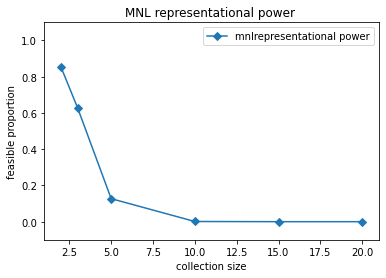

In [85]:
plt.plot(collection_size,mnl_feas_mean,'D-',label='mnlrepresentational power')
plt.xlim(collection_size[0]-1,collection_size[-1]+1)
plt.ylim(-0.1,1.1)
plt.xlabel('collection size')
plt.ylabel('feasible proportion')
plt.legend()
plt.title('MNL representational power ')

''' for a, b in zip(collection_size, mdm_feas_mean):
    plt.text(a, b, b, ha='center', va='top', fontsize=10,rotation=30) '''
    
plt.savefig('fig/mnl/mnl_rep_power_p'+str(n)+'alpha_'+str(alpha)+'.png')
plt.savefig('fig/mnl/mnl_rep_power_p'+str(n)+'alpha_'+str(alpha)+'.pdf')
plt.show()

In [236]:
print('start testing MDM feasibility')
start_mdm = time.time()
mdm_runtime_min = []
mdm_runtime_max = []
mdm_runtime_mean = []
mdm_all_feasibility = []
mdm_feas_mean = []
for i in range(len(all_instance)): # instance of the same collection size i 
    feasibility = []
    runtime = []
    for j in range(len(all_instance[i])): # under the same collection size, there are instances of the instance size
        rank = []
        curr_instance = all_instance[i][j]  
        raw_rank = np.argsort(curr_instance,axis=1)  
        # the indexes of all the enties are in increasing order in each row (product)
        # note that this argsort admits equal cases with index in increasing order
        # eg.
        ''' x =np.array([[1,1,0],[0,0,0],[0,0,1]]) is also feasible for the system means  '''
        for k in range(curr_instance.shape[0]): # find all the assortments in each product
            for l in np.nonzero(curr_instance[k]): 
                if len(l)>1: 
                    rank.append(raw_rank[k][-len(l):]) # take the ranking of the nonzero entries
        # add the reverse order of the equal probabilities
        #print(type(curr_instance))
        equal = []
        for k in range(curr_instance.shape[0]):
            for l in np.unique(curr_instance[k]):
                if l == 0 or l==1:
                    continue
                idx = np.flipud(np.argwhere(curr_instance[k] == l))
                if len(idx)>1:
                    print('check',idx)
                    idx = idx.reshape(1,-1).squeeze(0)
                    equal.append(idx)
                    ''' print('check the corresponding k th row of the rank ',rank[k])
                    print('check the corresponding element',idx)
                    print('element check',np.isin(idx,rank[k])) '''
                    print(len(idx))
                    if (True in np.isin(idx,rank[k])):
                        if len(rank[k])==2: #only with 
                            rank.pop(k) # only with 1 pair of equal probabilities of the row. 
                        else:
                            for ii in idx[:-1]:
                                rank[k] = rank[k].delete(ii) # leaving only 1 idex of the eqaul probability in the rank 
 
        
        result = mdm_feasibility(all_instance[i][j],rank,equal)
        feasibility.append(result[0])
        runtime.append(result[1])

    test = pd.DataFrame({'feasibility':feasibility,'runtime':runtime})
    test.to_csv('results/mdm/p_size'+str(n)+'csize'+str(collection_size[i])+'alpha_'+str(alpha)+'.csv')
    mdm_all_feasibility.append(feasibility)
    mdm_feas_mean.append(sum(feasibility)/instance_size)
    runtime = np.array(runtime)
    mdm_runtime_min.append(np.min(runtime))
    mdm_runtime_max.append(np.max(runtime))
    mdm_runtime_mean.append(np.mean(runtime))
print('the total run time of MDM test\n',time.time()-start_mdm) 
 

start testing MDM feasibility
the total run time of MDM test
 5.167277097702026


performance of mdm

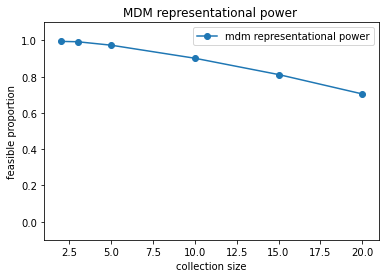

In [237]:
plt.plot(collection_size,mdm_feas_mean,'o-',label='mdm representational power')
plt.xlim(collection_size[0]-1,collection_size[-1]+1)
plt.ylim(-0.1,1.1)
plt.xlabel('collection size')
plt.ylabel('feasible proportion')
plt.legend()
plt.title('MDM representational power ')

''' for a, b in zip(collection_size, mdm_feas_mean):
    plt.text(a, b, b, ha='center', va='top', fontsize=10,rotation=30) '''
    
plt.savefig('fig/mdm/mdm_rep_power_p'+str(n)+'alpha_'+str(alpha)+'.png')
plt.savefig('fig/mdm/mdm_rep_power_p'+str(n)+'alpha_'+str(alpha)+'.pdf')
plt.show()

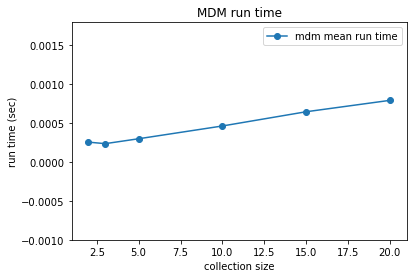

In [238]:
plt.plot(collection_size,mdm_runtime_mean,'o-',label = 'mdm mean run time')
#plt.plot(collection_size,runtime_min,label = 'min run time')
#plt.plot(collection_size,runtime_max, label = 'max run time')
plt.xlim(collection_size[0]-1,collection_size[-1]+1)
plt.ylim(-0.001,np.max(np.array(mdm_runtime_mean))+0.001)
plt.xlabel('collection size')
plt.ylabel('run time (sec)')
plt.legend()
plt.title('MDM run time')
plt.savefig('fig/mdm/runtime_p'+str(n)+'alpha_'+str(alpha)+'.png')
plt.savefig('fig/mdm/runtime_p'+str(n)+'alpha_'+str(alpha)+'.pdf')
plt.show()

In [239]:
print(mdm_feas_mean)
test = pd.DataFrame({'collection':collection_size,'feasible percentage':mdm_feas_mean})
test.to_csv('summary/mdm/p_'+str(n)+'_std'+str(std)+'alpha_'+str(alpha)+'.csv') 

[0.995, 0.993, 0.974, 0.902, 0.812, 0.705]


In [240]:
print('MDM testing completed')  

MDM testing completed


In [241]:
print('start testing RUM feasibility')
start_rum = time.time()

rum_runtime_min = []
rum_runtime_max = []
rum_runtime_mean = []
rum_all_feasibility = []
rum_feas_mean = []
for i in range(len(all_instance)): # instance of the same collection size i 
    feasibility = []
    runtime = []
    for j in range(len(all_instance[i])): # under the same collection size, there are instances of the instance size
        result = rum_feasibility(all_instance[i][j])
        feasibility.append(result[0])
        runtime.append(result[1])

    test = pd.DataFrame({'feasibility':feasibility,'runtime':runtime})
    test.to_csv('results/rum/p_size'+str(n)+'csize'+str(collection_size[i])+'alpha_'+str(alpha)+'.csv')
    rum_all_feasibility.append(feasibility)
    rum_feas_mean.append(sum(feasibility)/instance_size)
    runtime = np.array(runtime)
    rum_runtime_min.append(np.min(runtime))
    rum_runtime_max.append(np.max(runtime))
    rum_runtime_mean.append(np.mean(runtime))
    
print('the total run time of RUM test\n',time.time()-start_rum)     
 

start testing RUM feasibility
the total run time of RUM test
 3757.85502910614


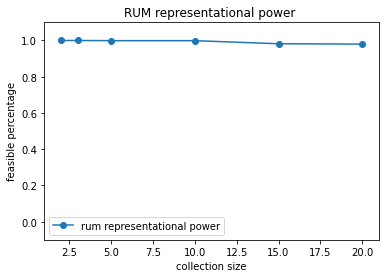

In [242]:
''' representational power '''
plt.plot(collection_size,rum_feas_mean,'o-',label='rum representational power')
plt.xlim(collection_size[0]-1,collection_size[-1]+1)
plt.ylim(-0.1,1.1)
plt.xlabel('collection size')
plt.ylabel('feasible percentage')
plt.legend()
plt.title('RUM representational power ')

''' for a, b in zip(collection_size, rum_feas_mean):
    plt.text(a, b, b, ha='center', va='top', fontsize=10,rotation=30) '''
    
plt.savefig('fig/rum/rum_rep_power_p'+str(n)+'alpha_'+str(alpha)+'.png')
plt.savefig('fig/rum/rum_rep_power_p'+str(n)+'alpha_'+str(alpha)+'.pdf')
plt.show()

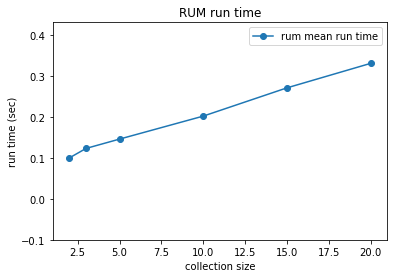

In [243]:
plt.plot(collection_size,rum_runtime_mean,'o-',label = 'rum mean run time')
#plt.plot(collection_size,runtime_min,label = 'min run time')
#plt.plot(collection_size,runtime_max, label = 'max run time')
plt.xlim(collection_size[0]-1,collection_size[-1]+1)
plt.ylim(-0.1,np.max(np.array(rum_runtime_mean))+0.1)
plt.xlabel('collection size')
plt.ylabel('run time (sec)')
plt.legend()
plt.title('RUM run time')
plt.savefig('fig/rum/runtime'+'_p'+str(n)+'alpha_'+str(alpha)+'.png')
plt.savefig('fig/rum/runtime'+'_p'+str(n)+'alpha_'+str(alpha)+'.pdf')
plt.show()

In [244]:
print(rum_feas_mean)
test2 = pd.DataFrame({'collection':collection_size,'feasible percentage':rum_feas_mean})
test2.to_csv('summary/rum/p_'+str(n)+'_std'+str(std)+'alpha_'+str(alpha)+'.csv') 

[1.0, 1.0, 0.999, 0.999, 0.982, 0.98]


In [245]:
print('RUM testing completed') 

RUM testing completed


summary of results

In [246]:
summay = pd.DataFrame({'collection':collection_size,'mdm':mdm_feas_mean,'rum':rum_feas_mean})
summay.to_csv('summary/summary_alpha_'+str(alpha)+'.csv')

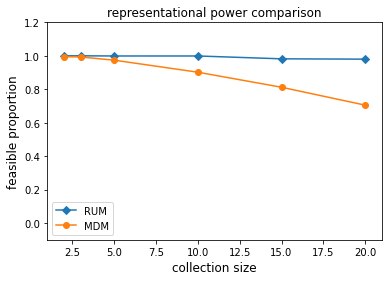

In [256]:
''' representational power '''
plt.plot(collection_size,rum_feas_mean,'D-',label = 'RUM')
plt.plot(collection_size,mdm_feas_mean,'o-',label = 'MDM')
plt.xlim(collection_size[0]-1,collection_size[-1]+1)
plt.ylim(-0.1,1.2)
plt.xlabel('collection size',fontsize = 12)
plt.ylabel('feasible proportion',fontsize = 12)
plt.legend()
plt.title('representational power comparison',fontsize = 12)

''' for e, f in zip(collection_size, rum_feas_mean):
    plt.text(e, f, f, ha='center', va='bottom', fontsize=10,rotation=38)

for a, b in zip(collection_size, mdm_feas_mean):
    plt.text(a, b, b, ha='center', va='top', fontsize=10,rotation=30)
    
for c, d in zip(collection_size, mnl_feas_mean):
    plt.text(c, d, d, ha='center', va='bottom', fontsize=10,rotation=30) '''


plt.savefig('fig/representational'+'_p'+str(n)+'alpha_'+str(alpha)+'.png')
plt.savefig('fig/representational'+'_p'+str(n)+'alpha_'+str(alpha)+'.pdf')
plt.show()

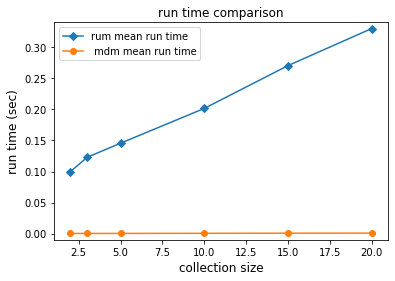

In [257]:
plt.plot(collection_size,rum_runtime_mean,'D-',label = 'rum mean run time')
plt.plot(collection_size,mdm_runtime_mean,'o-',label = ' mdm mean run time')
plt.xlim(collection_size[0]-1,collection_size[-1]+1)
plt.ylim(-0.01,np.max(np.array(rum_runtime_mean))+0.01)
plt.xlabel('collection size',fontsize = 12)
plt.ylabel('run time (sec)',fontsize = 12)
plt.legend()
plt.title('run time comparison',fontsize = 12)
plt.savefig('fig/runtime'+'_p'+str(n)+'alpha_'+str(alpha)+'.png')
plt.savefig('fig/runtime'+'_p'+str(n)+'alpha_'+str(alpha)+'.pdf')
plt.show()

In [249]:
trans_rum_rumtime = np.array(rum_runtime_mean)
trans_mdm_runtime = np.array(mdm_runtime_mean)

trans_rum_rumtime = np.log(trans_rum_rumtime)
trans_mdm_runtime = np.log(trans_mdm_runtime)


In [250]:
trans_mdm_runtime = list(trans_mdm_runtime)
trans_rum_rumtime = list(trans_rum_rumtime)


In [251]:
runtime_summary = pd.DataFrame({'collection':collection_size,'mdm':trans_mdm_runtime,'rum':trans_rum_rumtime})
runtime_summary.to_csv('summary/runtime_alpha_'+str(alpha)+'.csv')

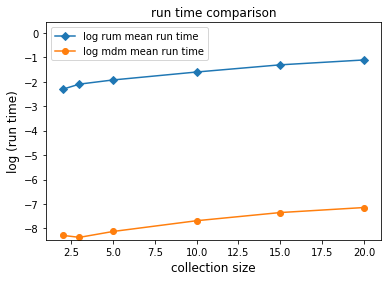

In [258]:
plt.plot(collection_size,trans_rum_rumtime,'D-',label = 'log rum mean run time')
plt.plot(collection_size,trans_mdm_runtime,'o-',label = 'log mdm mean run time')

#plt.plot(collection_size,runtime_min,label = 'min run time')
#plt.plot(collection_size,runtime_max, label = 'max run time')
plt.xlim(collection_size[0]-1,collection_size[-1]+1)
plt.ylim(-0.1+np.min(np.array(trans_mdm_runtime)),np.max(np.array(rum_runtime_mean))+0.1)
plt.xlabel('collection size',fontsize =12)
plt.ylabel('log (run time)',fontsize =12)
plt.legend()
plt.title('run time comparison',fontsize =12)
plt.savefig('fig/log_runtime_p'+str(n)+'alpha_'+str(alpha)+'.png')
plt.savefig('fig/log_runtime_p'+str(n)+'alpha_'+str(alpha)+'.pdf')
plt.show()

In [253]:
print('completed')

completed


In [254]:
''' an example for quick check '''
''' x = np.array([[0.3,0.9,0],[0.7,0,0.8],[0,0.1,0.2]]) # feasible
raw_rank = np.argsort(x,axis=1) # raw rank means rank the entries of each row in increasing order 2 
print(raw_rank) 

#next we want to find the rank of nonzero entries in each row 
rank = []
for j in range(x.shape[0]): # for each product
    for i in np.nonzero(x[j]): # the index of each row takes nonzero values means we know what assortment includes the current produt j # i in this line records the nonzero index vector
        rank.append(raw_rank[j][-len(i):]) # for each row in raw rank just take the last len(i) of nonzero elements
rank = np.array(rank)

for i in range(len(rank)):
    for j in range(len(rank[i])):
        rank[i][j].item()
print(rank)
print(type(rank))

result = mdm_feasibility(x,rank)
print(result) '''

' x = np.array([[0.3,0.9,0],[0.7,0,0.8],[0,0.1,0.2]]) # feasible\nraw_rank = np.argsort(x,axis=1) # raw rank means rank the entries of each row in increasing order 2 \nprint(raw_rank) \n\n#next we want to find the rank of nonzero entries in each row \nrank = []\nfor j in range(x.shape[0]): # for each product\n    for i in np.nonzero(x[j]): # the index of each row takes nonzero values means we know what assortment includes the current produt j # i in this line records the nonzero index vector\n        rank.append(raw_rank[j][-len(i):]) # for each row in raw rank just take the last len(i) of nonzero elements\nrank = np.array(rank)\n\nfor i in range(len(rank)):\n    for j in range(len(rank[i])):\n        rank[i][j].item()\nprint(rank)\nprint(type(rank))\n\nresult = mdm_feasibility(x,rank)\nprint(result) '

In [255]:
''' an infeasible case for checking equal probabilities '''
''' rank = []
y = np.array([[0.4,0.6,0.45],[0.4,0.4,0],[0.2,0,0.55]])
raw_rank = np.argsort(y)
for k in range(y.shape[0]):
    for l in np.nonzero(y[k]):
        if len(l)>1:
            rank.append(raw_rank[k][-len(l):])
print(rank)
for row in y:
    for i in np.unique(row):
        if i == 0 or i==1:
            continue
        idx = np.argwhere(row == i)
        idx = np.flipud(idx)
        idx = idx.reshape(1, -1).squeeze(0)
        if len(idx)>1:
            print(idx)
            rank.append(idx)
            print('index for {}:'.format(i), idx, row[idx])
print(rank)

result_y = mdm_feasibility(y,rank)
print(result_y) '''


" rank = []\ny = np.array([[0.4,0.6,0.45],[0.4,0.4,0],[0.2,0,0.55]])\nraw_rank = np.argsort(y)\nfor k in range(y.shape[0]):\n    for l in np.nonzero(y[k]):\n        if len(l)>1:\n            rank.append(raw_rank[k][-len(l):])\nprint(rank)\nfor row in y:\n    for i in np.unique(row):\n        if i == 0 or i==1:\n            continue\n        idx = np.argwhere(row == i)\n        idx = np.flipud(idx)\n        idx = idx.reshape(1, -1).squeeze(0)\n        if len(idx)>1:\n            print(idx)\n            rank.append(idx)\n            print('index for {}:'.format(i), idx, row[idx])\nprint(rank)\n\nresult_y = mdm_feasibility(y,rank)\nprint(result_y) "